# Polynomial Chaos Expansions (II)

We will take here an alternative route to fitting a PCE. Instead of gradient descent, we will use `tntorch`'s class `tn.PCEInterpolator`, which finds a sparse set of coefficients via least angle regression (LARS). See [1] for more details on this PCE approach.

[1] ["Data-driven Polynomial Chaos Expansion for Machine Learning Regression", Torre et al. 2020](https://www.sciencedirect.com/science/article/pii/S0021999119302220)


In [1]:
import torch
torch.set_default_dtype(torch.float64)
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

We will fit [Branin function](https://www.sfu.ca/~ssurjano/branin.html), which is two-dimensional:

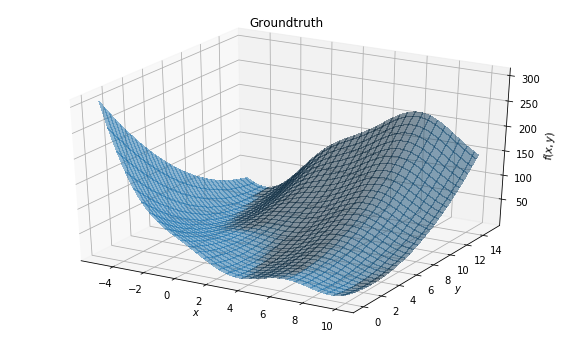

In [2]:
def branin(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    t = 1 / (8 * np.pi)
    s = 10
    r = 6
    c = 5 / np.pi
    b = 5.1 / (4 * np.pi**2)
    a = 1

    term1 = a * (x2 - b * x1**2 + c * x1 - r)**2
    term2 = s * (1 - t) * torch.cos(x1)

    return term1 + term2 + s

N = 2
P = 100
I = 64

# Let us generate a few training data points
X_train = torch.rand(P, N)
X_train[:, 0] = X_train[:, 0]*15-5
X_train[:, 1] = X_train[:, 1]*15
y_train = branin(X_train)

domain = [torch.linspace(-5, 10, I), torch.linspace(0, 15, I)]
x1, x2 = torch.meshgrid(domain)
grid = torch.cat([x1.flatten()[:, None], x2.flatten()[:, None]], dim=1)
groundtruth = branin(grid).reshape(I, I)

fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
ax.plot_surface(x1.numpy(), x2.numpy(), groundtruth.numpy(), alpha=0.5,
                       linewidth=5, antialiased=False)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_zlabel('$f(x, y)$')
plt.title('Groundtruth')
plt.show()

Next, we build a PCE interpolator that regresses the training points. The main hyperparameters are $p$ (default value: 5) and $0 \le q \le 1$ (default value: 0.75). In this case, `p=8` works better to capture the function's details:

In [3]:
pce = tn.PCEInterpolator()
pce.fit(X_train, y_train, p=8)

PCE interpolation (p=8, q=0.75) of 100 points (90 train + 10 val) in 2D
0.000s | Hyperbolic truncation... done, we kept 30 / 64 candidates
0.001s | Assembling a 100 X 30 design matrix... done
0.005s | Finding best nnz in LARS... done, val eps=0.044794
0.011s | Retraining at nnz=18... done, training eps=0.028726
0.020s



We are now ready to convert this interpolation to a TT-Tucker compressed tensor over a discrete domain:

In [4]:
t = pce.to_tensor(domain=domain)

Conversion to TT-Tucker format (rmax=200, eps=0.001)
0.000s | Sparse TT-SVD... done, rmax=3, eps=0.00028102
0.013s



Let's visualize the results:

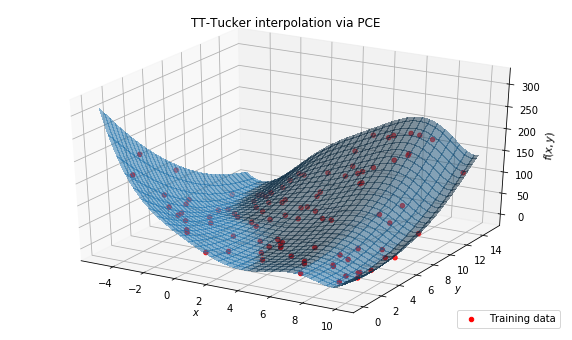

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
ax.plot_surface(x1.numpy(), x2.numpy(), t.numpy(),
                linewidth=5, antialiased=False, alpha=0.5)
plt.gca().scatter(X_train[:, 0].numpy(), X_train[:, 1].numpy(), y_train.numpy(), color='red', label='Training data')
plt.legend(loc='lower right')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_zlabel('$f(x, y)$')
plt.title('TT-Tucker interpolation via PCE')
plt.show()